In [2]:
import pandas as pd
from sqlalchemy import create_engine

import datetime as dt

# Put postgreSQL credeitials into sql_login.py
from sql_login import USERNAME as USERNAME
from sql_login import PASSWORD as PASSWORD

import matplotlib.pyplot as plt

In [3]:
rds_connection_string = USERNAME+':'+PASSWORD+"@localhost:5432/avocados"
engine = create_engine(f'postgresql://{rds_connection_string}')
conn = engine.engine.connect()

In [4]:
pd.read_sql("SELECT c.date, c.close, a.price FROM cmg AS c INNER JOIN avo_price AS a ON c.date=a.date", conn)

,date,close,price
0,2016-01-04,448.809998,0.870412
1,2019-01-07,485.149994,1.039436


In [9]:
# Data in avocado price csv file has only prices on Satrudays.
avocado_price_dates_df = pd.read_sql("SELECT date FROM avo_price;", conn)
avocado_price_dates_df['date'] = pd.to_datetime(avocado_price_dates_df['date'])
avo_price_date_ser= (avocado_price_dates_df.iloc[:,0]).dt.dayofweek

all_days_sunday = True
for i in range(0,10):
    day = avo_price_date_ser[i]
    if day != 6:
        all_days_sunday = False
if all_days_sunday:
    print('All dates are Sundays')
else:
    print('Some dates are not Sundays')

All dates are Sundays


In [11]:
stock_price_dates_df = pd.read_sql("SELECT date, close FROM cmg;", conn)
stock_price_dates_df['date'] =  pd.to_datetime(stock_price_dates_df['date'])
stock_price_dates_df['days to add'] =  6-pd.to_datetime(stock_price_dates_df['date']).dt.dayofweek

new_date_list=[]
for j in range(0,stock_price_dates_df.shape[0]):
    new_date_list.append(stock_price_dates_df.iloc[j,0]+dt.timedelta(days = int(stock_price_dates_df.iloc[j,2])))
stock_price_dates_df['new date'] = new_date_list
    
stock_price_dates_df.head(20)

,date,close,days to add,new date
0,2015-01-02,678.400024,2,2015-01-04
1,2015-01-05,667.690002,6,2015-01-11
2,2015-01-06,664.380005,5,2015-01-11
3,2015-01-07,694.260010,4,2015-01-11
4,2015-01-08,719.989990,3,2015-01-11
5,2015-01-09,714.270019,2,2015-01-11
6,2015-01-12,711.700012,6,2015-01-18
7,2015-01-13,714.059998,5,2015-01-18
8,2015-01-14,709.739990,4,2015-01-18
9,2015-01-15,700.780029,3,2015-01-18


In [36]:
dates_df_len = stock_price_dates_df.shape[0]

weekly_stock_data_df = pd.DataFrame(columns=('close', 'new date'))

index = 0
prev = stock_price_dates_df.iloc[0,2]
for j in range(1,dates_df_len):
    next = stock_price_dates_df.iloc[j,2]
    if prev < next:
        weekly_stock_data_df.loc[index] = [stock_price_dates_df.iloc[j,1],stock_price_dates_df.iloc[j,3]]
        index += 1
    prev = next
weekly_stock_data_df

,close,new date
0,667.690002,2015-01-11
1,711.700012,2015-01-18
2,705.780029,2015-01-25
3,723.429993,2015-02-01
4,712.549988,2015-02-08
...,...,...
257,827.030029,2019-12-15
258,822.789978,2019-12-22
259,828.289978,2019-12-29
260,836.070007,2020-01-05


In [39]:
week_price_df = pd.read_sql("SELECT date, price FROM avo_price", conn)
week_price_df['date'] =  pd.to_datetime(week_price_df['date'])
week_price_df 

,date,price
0,2015-01-04,0.957502
1,2015-01-11,1.019967
2,2015-01-18,1.044620
3,2015-01-25,1.052524
4,2015-02-01,0.902667
...,...,...
248,2019-11-03,1.061531
249,2019-11-10,1.035006
250,2019-11-17,1.042074
251,2019-11-24,1.081343


In [40]:
merged_df = weekly_stock_data_df.merge(week_price_df , left_on='new date', right_on='date')

In [41]:
merged_df

,close,new date,date,price
0,667.690002,2015-01-11,2015-01-11,1.019967
1,711.700012,2015-01-18,2015-01-18,1.044620
2,705.780029,2015-01-25,2015-01-25,1.052524
3,723.429993,2015-02-01,2015-02-01,0.902667
4,712.549988,2015-02-08,2015-02-08,0.962303
...,...,...,...,...
243,782.609985,2019-11-03,2019-11-03,1.061531
244,751.770019,2019-11-10,2019-11-10,1.035006
245,743.369995,2019-11-17,2019-11-17,1.042074
246,771.309998,2019-11-24,2019-11-24,1.081343


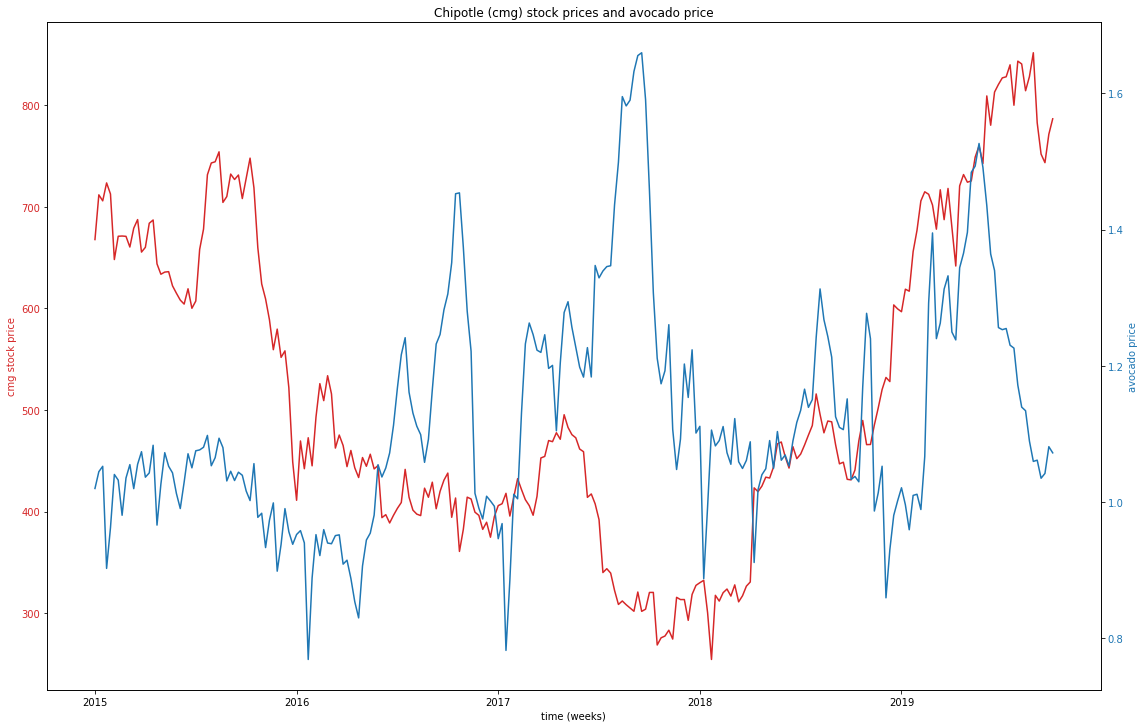

In [62]:
x = [j for j in range(0,248)]

fig, ax1 = plt.subplots(figsize = (16,10))

color = 'tab:red'
ax1.set_xlabel('time (weeks)')
ax1.set_ylabel('cmg stock price', color=color)
ax1.plot(x, merged_df['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks([j for j in range(0,248,52)], range(2015,2020))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('avocado price', color=color)  # we already handled the x-label with ax1
ax2.plot(x, merged_df['price'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Chipotle (cmg) stock prices and avocado price')
plt.savefig('Images/cmg_and_avo_prices.png')
plt.show()